# Introduction

The US Geologic Survey, the federal agency that maintains stream gages, is entering the 21st century by making it easier to find and retrieve their data. Most development so far has been in R, but a few blessed individuals have been developing a similar package in Python, [dataretrieval](https://github.com/USGS-python/dataretrieval)

# Learning objectives

- Practice data analysis skills with `pandas` and plotting skills with `matplotlib`
- Recognize [RESTful APIs](https://www.codecademy.com/article/what-is-rest) and formulaic, automated data retrieval from agencies like the USGS with `dataretrieval`
- Test concepts of watershed hydrology addressed in textbook and lecture with real-life data
- Devise algorithmic approaches to analyzing time series data

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from dataretrieval import nwis
import pandas as pd
import numpy as np

# Retrieve and clean some site data

Remember this figure from your lecture?

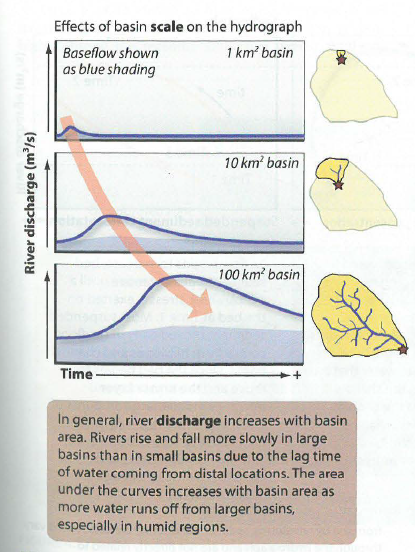

Let's use some real-life data to see if the real-world version looks anything like the idealized version! I have selected three nested watersheds in New Hampshire by their stream gage IDs (I looked at a map)

In [2]:
# Make a list of strings corresponding to site IDs. 
# These use quotes to denote they are strings and not numbers
# They are separated by commas and bound by square brackets

sitelist = ["01075000", "01081500", "01092000"]

Let's look at the available data of our `sitelist` variable

In [3]:
site_info = nwis.get_record(sites=sitelist, service='site')

print('Available data are:\n', site_info.columns.values) # "\n" just puts a line break in a text (string)
print('Station names are:\n', site_info['station_nm'])


Available data are:
 ['agency_cd' 'site_no' 'station_nm' 'site_tp_cd' 'lat_va' 'long_va'
 'dec_lat_va' 'dec_long_va' 'coord_meth_cd' 'coord_acy_cd'
 'coord_datum_cd' 'dec_coord_datum_cd' 'district_cd' 'state_cd'
 'county_cd' 'country_cd' 'land_net_ds' 'map_nm' 'map_scale_fc' 'alt_va'
 'alt_meth_cd' 'alt_acy_va' 'alt_datum_cd' 'huc_cd' 'basin_cd' 'topo_cd'
 'instruments_cd' 'construction_dt' 'inventory_dt' 'drain_area_va'
 'contrib_drain_area_va' 'tz_cd' 'local_time_fg' 'reliability_cd'
 'gw_file_cd' 'nat_aqfr_cd' 'aqfr_cd' 'aqfr_type_cd' 'well_depth_va'
 'hole_depth_va' 'depth_src_cd' 'project_no']
Station names are:
 0                 PEMIGEWASSET RIVER AT WOODSTOCK, NH
1            MERRIMACK RIVER AT FRANKLIN JUNCTION, NH
2    MERRIMACK R NR GOFFS FALLS, BELOW MANCHESTER, NH
Name: station_nm, dtype: object


Using my data calls as an example, find the coordinates of these sites. You can find what these dizzying terms mean in this [hard-to-find example webpage from the USGS](https://waterservices.usgs.gov/nwis/site/?siteOutput=Expanded&site=01075000). For your own reference, plot them as locations in Google Maps or the mapping program of your choosing. 

In [30]:
print('Station details are:\n', site_info['long_va'])

Station details are:
 0    714048
1    713912
2    712750
Name: long_va, dtype: int64


In [4]:
# Initialize a blank dataframe object
df = pd.DataFrame()

In [5]:
# This loop will iterate through each of the objects in sitelist and assign it 
# a number "i" as it assigns the variable siteNumber to the sitelist object

for i, siteNumber in enumerate(sitelist):
    # This is the parameter code for discharge in cfs
    parameterCode = "00060"
    # These are strings of dates
    startDate = "2022-01-01"
    endDate = "2022-12-31"
    # Make a temporary dataframe to store the records of each site
    df_temp = nwis.get_record(sites=siteNumber, service='dv', start=startDate, end=endDate, parameterCd='00060')
    # And then concatenate (stick on vertically) each site's data to the previous sites' data
    df = pd.concat([df, df_temp])
    # This method keeps our dataframe compact - each of the sites have the same
    # data, and we can always parse by site number later

Parameter codes for the USGS are here:https://help.waterdata.usgs.gov/codes-and-parameters/parameters
To get discharge, use `"00060"`



In [6]:
df

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
2022-01-01 00:00:00+00:00,277.0,A,01075000
2022-01-02 00:00:00+00:00,377.0,A,01075000
2022-01-03 00:00:00+00:00,311.0,"A, e",01075000
2022-01-04 00:00:00+00:00,188.0,"A, e",01075000
2022-01-05 00:00:00+00:00,258.0,A,01075000
...,...,...,...
2022-12-27 00:00:00+00:00,22700.0,P,01092000
2022-12-28 00:00:00+00:00,16300.0,P,01092000
2022-12-29 00:00:00+00:00,12200.0,P,01092000


Now we're going to do a `groupby` that will [group rows with similar values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) for a certain column for analysis. After we `groupby`, we can query the values of a different column, but grouped by the first column. 

In this case the code is going to make three separate plots, one for each `site_no`, of the column `00060_Mean`, or mean daily discharge. 

site_no
01075000    Axes(0.125,0.2;0.775x0.68)
01081500    Axes(0.125,0.2;0.775x0.68)
01092000    Axes(0.125,0.2;0.775x0.68)
Name: 00060_Mean, dtype: object

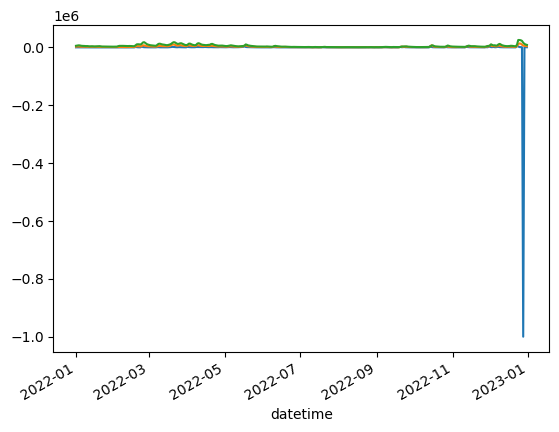

In [7]:
df.groupby(by='site_no')['00060_Mean'].plot()


Oh no gross! What's this?

In [8]:
df.groupby(by='site_no')['00060_Mean'].min()

site_no
01075000   -999999.0
01081500       537.0
01092000       721.0
Name: 00060_Mean, dtype: float64

Yike, that's our issue! That one site has some invalid data or NoData, and the fill value is `-99999.0`. We can replace that with `nan`, or "not a number".

In [9]:
df.replace(-999999.0, np.nan, inplace=True)

How about now?

In [10]:
df.groupby(by='site_no')['00060_Mean'].min()

site_no
01075000     65.1
01081500    537.0
01092000    721.0
Name: 00060_Mean, dtype: float64

You may notice that there are codes associated with each measurement in `00060_Mean_cd`. The The `P` values are provisional data. We can create a dataframe with only non-provisional data by [subsetting](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html) the data:

In [11]:
no_prov = df[df['00060_Mean_cd'] != 'P']
no_prov

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
2022-01-01 00:00:00+00:00,277.0,A,01075000
2022-01-02 00:00:00+00:00,377.0,A,01075000
2022-01-03 00:00:00+00:00,311.0,"A, e",01075000
2022-01-04 00:00:00+00:00,188.0,"A, e",01075000
2022-01-05 00:00:00+00:00,258.0,A,01075000
...,...,...,...
2022-10-29 00:00:00+00:00,5510.0,A,01092000
2022-10-30 00:00:00+00:00,3910.0,A,01092000
2022-10-31 00:00:00+00:00,3340.0,A,01092000


The code selects rows from a pandas dataframe 'df' where the value in the column '00060_Mean_cd' is not equal to (`!=`)'P'. The resulting dataframe is then stored in the variable 'no_prov'. In simpler terms, the code filters out rows from the dataframe where the value in a particular column is 'P' and stores the remaining rows in a new dataframe called 'no_prov'.

^^^ I had ChatGPT write that summary! I asked it "translate this block of code into a simple English explanation". Fun. 

# Part one: Comparing some hydrographs

Whew. Now let's plot.

Text(0, 0.5, 'Streamflow (cfs)')

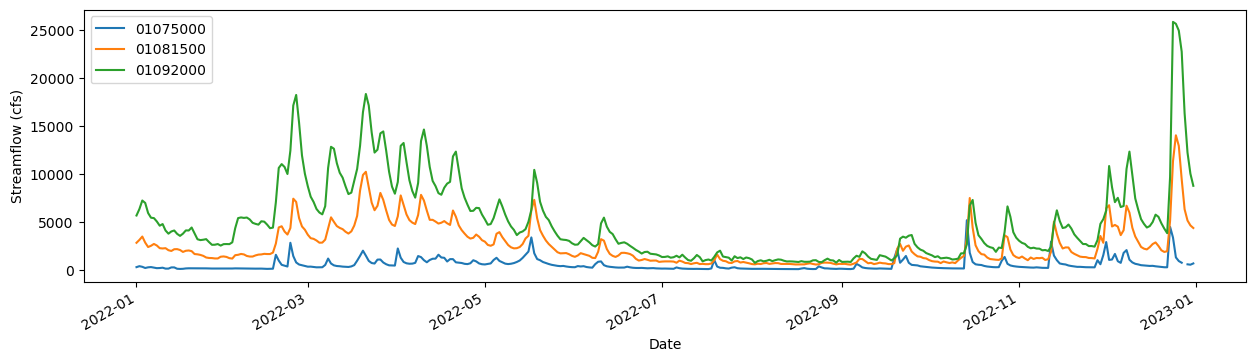

In [12]:
fig, ax = plt.subplots(figsize=(15,4))

for site, group in df.groupby(by='site_no'):
    
    # site_info = nwis.get_record(sites=site, service='site')

    group.plot(y='00060_Mean', ax=ax, legend=True, label=site)

ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

#https://stackoverflow.com/questions/39902522/pandas-groupby-object-in-legend-on-plot

Very cool!

1. Which plot represents the watershed with the smallest drainage area? The largest? How do you know?
2. How might you write an algorithm to determine the timing between peak discharges between upstream and downstream sites?
3. Are the upstream sites always a consistent percentage of the downstream sites' discharges? Why or why not? How might that be explained? What other data might you need to test this idea? BONUS: How might you write an algorithm to track how the relative streamflows change with time? 

Your answers here.

In [13]:
# And maybe a plot without provisional data here

Now it's your turn. Use the [National Water Dashboard](https://dashboard.waterdata.usgs.gov/app/nwd/?region=lower48&aoi=default) to pick a stream gage and tell me a story!

In [14]:
# Do sick coding here

Give me a few sentences about the story you've told me here

# Part two: Flood recurrence 

Site 01081500 has been gaged since 1903, but there's a data gap in the 80s. Let's go with 01092000, gaged since the 40s. 

In [15]:
# Let's call this new dataframe "df_hist" for historical data, 
# so we don't get confused 

df_hist = nwis.get_record(sites='01092000', service='dv', start='1900-01-01', end=endDate, parameterCd='00060')

Text(0, 0.5, 'Streamflow (cfs)')

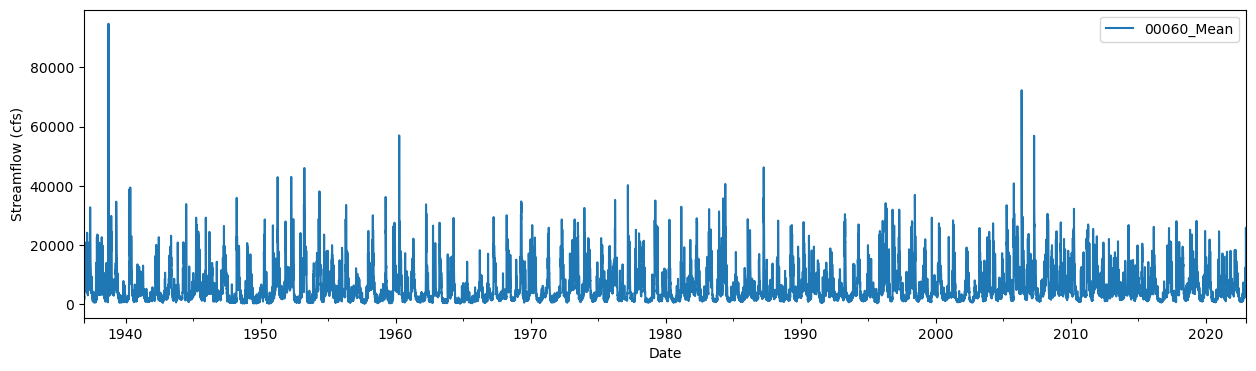

In [16]:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

What do these data look like?

In [17]:
df_hist.head()


,00060_Mean,00060_Mean_cd,site_no
datetime,,,
1936-11-21 00:00:00+00:00,2770.0,A,01092000
1936-11-22 00:00:00+00:00,1020.0,A,01092000
1936-11-23 00:00:00+00:00,2260.0,A,01092000
1936-11-24 00:00:00+00:00,1830.0,A,01092000
1936-11-25 00:00:00+00:00,2580.0,A,01092000


Cool! Each entry in `datetime` is a date of a year with the maximum streamflow. Now if we're interested in recurrence intervals, we're gonna have to manipulate this dataset a little. I'll get you started creating a ranking for these flows, and then you'll be in charge of calculating recurrence intervals

Note: I know this isn't water year. I'll fix this at some point. 

In [18]:
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

# This is a slightly weird thing, where the datetime is stored as an "index"
# of the dataframe rather than a column, so I first turned the index into 
# a datetime object with the pd.to_datetime(df_hist.index) call, 
# and then parsed that datetime object for the year

df_hist.head() 

,00060_Mean,00060_Mean_cd,site_no,year
datetime,,,,
1936-11-21 00:00:00+00:00,2770.0,A,01092000,1936
1936-11-22 00:00:00+00:00,1020.0,A,01092000,1936
1936-11-23 00:00:00+00:00,2260.0,A,01092000,1936
1936-11-24 00:00:00+00:00,1830.0,A,01092000,1936
1936-11-25 00:00:00+00:00,2580.0,A,01092000,1936


In [19]:
# Here I'm going to ask "What is the maximum value for each year?" the groupby()
# function puts all the things that have the same value in a specified column
# and then finds the max value, in this case 
# Read more here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

annual_max_floods = df_hist.groupby('year').max().reset_index()

# The groupby() function creates this new mini-dataframe, "annual_max_floods",
# which can be manipulated just like our original dataframe, df_hist


# the reset_index() call is just a little nuance where I don't want it to turn
# my year groups into the index of the dataframe, or else Pandas will thing
# I want to plot variables as a timeline, which I don't want to do 

annual_max_floods

,year,00060_Mean,00060_Mean_cd,site_no
0,1936,20900.0,A,01092000
1,1937,32700.0,A,01092000
2,1938,94800.0,A,01092000
3,1939,34600.0,A,01092000
4,1940,39400.0,A,01092000
...,...,...,...,...
82,2018,25100.0,"A, e",01092000
83,2019,28100.0,"A, e",01092000
84,2020,24600.0,"A, e",01092000
85,2021,18000.0,"A, e",01092000


Cool, so you know "N" now, let's find r

In [20]:
# Here I'm asking Pandas to rank the discharge column in descending order...

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

# ...and then show them to me sorted!

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
annual_max_floods.sort_values(by=['rank'])

,year,00060_Mean,00060_Mean_cd,site_no,rank
2,1938,94800.0,A,01092000,1.0
70,2006,72300.0,"A, e",01092000,2.0
24,1960,57000.0,A,01092000,3.0
71,2007,56900.0,"A, e",01092000,4.0
51,1987,46200.0,"A, e",01092000,5.0
...,...,...,...,...,...
85,2021,18000.0,"A, e",01092000,83.0
49,1985,17600.0,A,01092000,84.0
55,1991,14800.0,"A, e",01092000,85.0
29,1965,14300.0,A,01092000,86.0


Now you have N and r, which is all you need. Let's take a look at the data....

<Axes: xlabel='rank', ylabel='00060_Mean'>

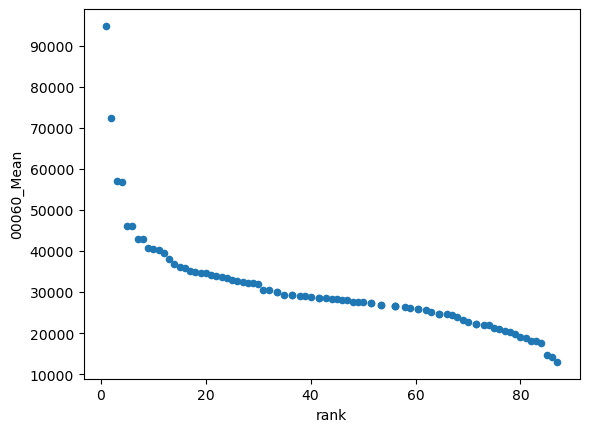

In [21]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html
annual_max_floods.plot.scatter(x='rank',y='00060_Mean')

# Why don't you edit the above code to:
# Properly label x and y axes
# maybe...add the year as a color for the data points?

Now let's find flood recurrence interval: Recurrence Interval equals the number of years, plus one, divided by the magnitude rank for which you wish to calculate the recurrence interval.

Recurrence Interval = (Years + 1) / Rank

More here: https://www.usgs.gov/special-topics/water-science-school/science/floods-and-recurrence-intervals

In [22]:
# Don't forget, you can treat a column name like a variable and do math on the whole column
# Here's an example where we convert the cfs to cubic meters per second

annual_max_floods['Discharge_m3_s-1'] = annual_max_floods['00060_Mean'] / 35.315
annual_max_floods.head()

,year,00060_Mean,00060_Mean_cd,site_no,rank,Discharge_m3_s-1
0,1936,20900.0,A,01092000,76.0,591.816509
1,1937,32700.0,A,01092000,26.0,925.952145
2,1938,94800.0,A,01092000,1.0,2684.411723
3,1939,34600.0,A,01092000,20.0,979.753646
4,1940,39400.0,A,01092000,12.0,1115.673227


In [23]:
# Your code here

Can you recreate Figure 4.13 from your textbook, where recurrence interval is plotted (on a log scale) on the x axis and peak discharge is plotted on the Y axis?

In [24]:
# Your plot here

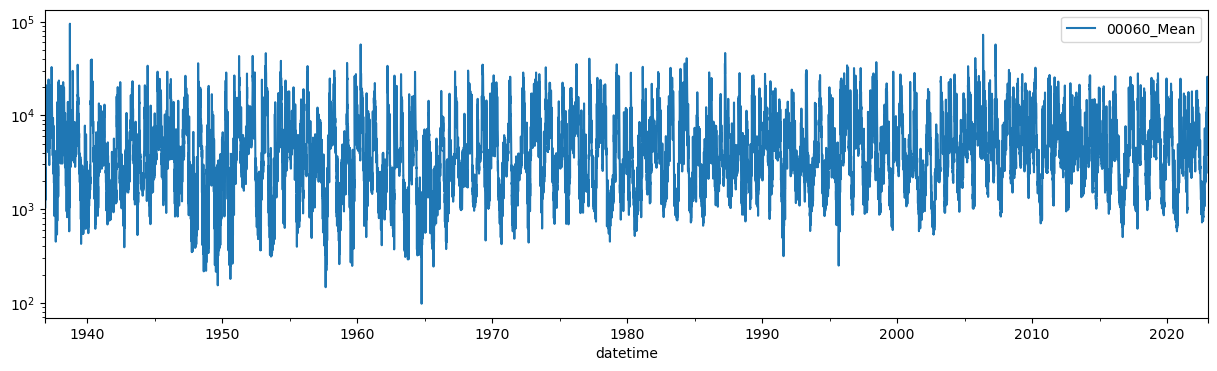

In [25]:
# If you need a hint for how to make a log scale, 
# I'll show you an example with the discharge data:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_yscale('log')

(Yes, ugly but now you know the syntax!)

# Deliverables checklist

Part One:
 - Map of gage locations
 - Answers to three questions
 - A gage story

Part Two:
 - Prettier rank-vs-peak-flow plot
 - Recurrence interval calculated
 - Recurrence interval plot

